Some ideas to explore:

> * Various relationships between movie budget, revenues, genres, ratings, release date, production company, and language.
> * How have budgets and revenues for movies changed over time? 
> * Are there relationships between the budget for a movie and how much revenue it generates? 
> * Do certain genres of movies generate more revenue than others? Higher ratings than others?
> * Does runtime impact budget, revenue, or rating?

In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval
import seaborn as sns

In [51]:
movies_meta = pd.read_csv('./archive/movies_metadata.csv')
movies_meta.head(2)

/Users/coxem/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


In [52]:
movies_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

In [53]:
movies_meta = movies_meta[['adult', 'budget', 'genres', 'id', 'imdb_id', 'original_language', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'title', 'video', 'vote_average', 'vote_count']]

In [54]:
movies_meta.head(2)

,adult,budget,genres,id,imdb_id,original_language,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,video,vote_average,vote_count
0,False,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,tt0114709,en,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Toy Story,False,7.7,5415.0
1,False,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,tt0113497,en,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Jumanji,False,6.9,2413.0


In [55]:
movies_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   adult                 45466 non-null  object 
 1   budget                45466 non-null  object 
 2   genres                45466 non-null  object 
 3   id                    45466 non-null  object 
 4   imdb_id               45449 non-null  object 
 5   original_language     45455 non-null  object 
 6   production_companies  45463 non-null  object 
 7   production_countries  45463 non-null  object 
 8   release_date          45379 non-null  object 
 9   revenue               45460 non-null  float64
 10  runtime               45203 non-null  float64
 11  spoken_languages      45460 non-null  object 
 12  status                45379 non-null  object 
 13  title                 45460 non-null  object 
 14  video                 45460 non-null  object 
 15  vote_average       

In [56]:
movies_meta['genres'].describe()

count                             45466
unique                             4069
top       [{'id': 18, 'name': 'Drama'}]
freq                               5000
Name: genres, dtype: object

In [57]:
genres_df = pd.DataFrame(movies_meta['genres'])
genres_df

,genres
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '..."
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '..."
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ..."
3,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam..."
4,"[{'id': 35, 'name': 'Comedy'}]"
...,...
45461,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n..."
45462,"[{'id': 18, 'name': 'Drama'}]"
45463,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam..."
45464,[]


In [58]:
genres_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   genres  45466 non-null  object
dtypes: object(1)
memory usage: 355.3+ KB


In [59]:
genres_df.genres = genres_df.genres.apply(lambda x: literal_eval(x))

In [60]:
genres_df.genres

0        [{'id': 16, 'name': 'Animation'}, {'id': 35, '...
1        [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...
2        [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...
3        [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...
4                           [{'id': 35, 'name': 'Comedy'}]
                               ...                        
45461    [{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...
45462                        [{'id': 18, 'name': 'Drama'}]
45463    [{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...
45464                                                   []
45465                                                   []
Name: genres, Length: 45466, dtype: object

In [61]:
genres_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   genres  45466 non-null  object
dtypes: object(1)
memory usage: 355.3+ KB


In [62]:
def genres_cleaner(list_of_dicts):
    return [ d['name'] for d in list_of_dicts ] 

In [63]:
genres_list = genres_df['genres'].map(genres_cleaner)
genres_list

0         [Animation, Comedy, Family]
1        [Adventure, Fantasy, Family]
2                   [Romance, Comedy]
3            [Comedy, Drama, Romance]
4                            [Comedy]
                     ...             
45461                 [Drama, Family]
45462                         [Drama]
45463       [Action, Drama, Thriller]
45464                              []
45465                              []
Name: genres, Length: 45466, dtype: object

In [64]:
movies_meta['genres'] = genres_list
movies_meta.head()

,adult,budget,genres,id,imdb_id,original_language,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,video,vote_average,vote_count
0,False,30000000,"[Animation, Comedy, Family]",862,tt0114709,en,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Toy Story,False,7.7,5415.0
1,False,65000000,"[Adventure, Fantasy, Family]",8844,tt0113497,en,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Jumanji,False,6.9,2413.0
2,False,0,"[Romance, Comedy]",15602,tt0113228,en,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Grumpier Old Men,False,6.5,92.0
3,False,16000000,"[Comedy, Drama, Romance]",31357,tt0114885,en,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Waiting to Exhale,False,6.1,34.0
4,False,0,[Comedy],11862,tt0113041,en,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Father of the Bride Part II,False,5.7,173.0


In [107]:
genres_counts = genres_list.explode().value_counts()
genres_counts

Drama                                    20265
Comedy                                   13182
Thriller                                  7624
Romance                                   6735
Action                                    6596
Horror                                    4673
Crime                                     4307
Documentary                               3932
Adventure                                 3496
Science Fiction                           3049
Family                                    2770
Mystery                                   2467
Fantasy                                   2313
Animation                                 1935
Foreign                                   1622
Music                                     1598
History                                   1398
War                                       1323
Western                                   1042
TV Movie                                   767
Mardock Scramble Production Committee        1
The Cartel   

In [108]:
genres_counts_df = genres_counts.to_frame('counts').reset_index()
genres_counts_df = genres_counts_df.rename(columns = {'index': 'genre'})
genres_counts_df

,genre,counts
0,Drama,20265
1,Comedy,13182
2,Thriller,7624
3,Romance,6735
4,Action,6596
5,Horror,4673
6,Crime,4307
7,Documentary,3932
8,Adventure,3496
9,Science Fiction,3049


In [109]:
genres_counts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   genre   32 non-null     object
 1   counts  32 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 640.0+ bytes


In [110]:
genres_counts_df = genres_counts_df[genres_counts_df.counts > 1]
genres_counts_df

,genre,counts
0,Drama,20265
1,Comedy,13182
2,Thriller,7624
3,Romance,6735
4,Action,6596
5,Horror,4673
6,Crime,4307
7,Documentary,3932
8,Adventure,3496
9,Science Fiction,3049


In [171]:
#fig, ax = plt.subplots(figsize = (18, 8))
#x_data = genres_counts_df['genre']
#y_data = genres_counts_df['counts']

#ax.bar(x_data, y_data)

#ax.set_xlabel('Genre', fontsize = 20)
#ax.set_xticklabels(x_data, rotation = 45, fontsize = 20)
#ax.set_ylabel('# of Movies', fontsize = 20)
#ax.set_title('Counts of Movies by Genre', fontsize = 24)

#fig.tight_layout()

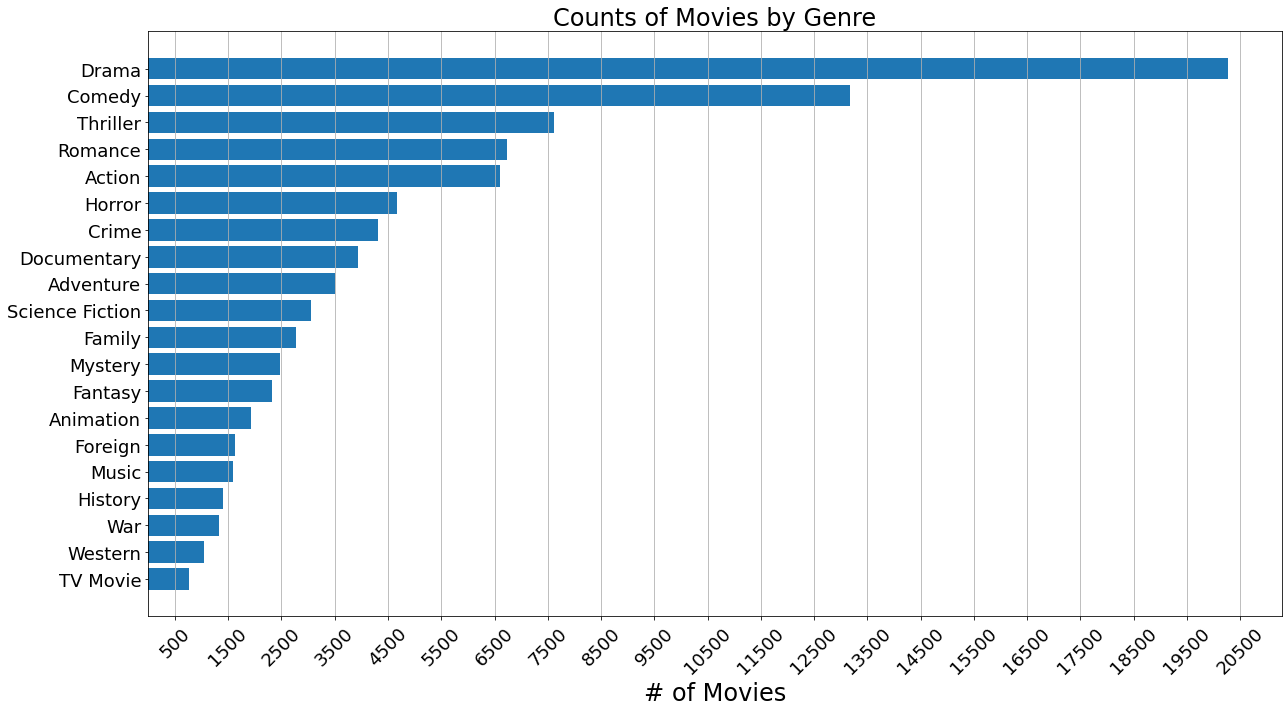

In [170]:
x_data = genres_counts_df['counts']
y_data = genres_counts_df['genre']
y = np.arange(len(y_data))
x = np.linspace(500, 20500, 21, dtype='int')


fig, ax = plt.subplots(figsize=(18,10))
ax.barh(y_data, x_data)
ax.invert_yaxis()
ax.set_yticks(y)
ax.set_xticks(x)
ax.set_xticklabels(x, fontsize = 18, rotation = 45)
ax.set_yticklabels(y_data, fontsize = 18)
ax.xaxis.grid(True)
#ax.set_ylabel('Genre', fontsize = 24)
ax.set_xlabel('# of Movies', fontsize = 24)
ax.set_title('Counts of Movies by Genre', fontsize = 24)
fig.tight_layout()

In [187]:
#genre_to_find = ['Drama']

In [194]:
#def check_genre(genre, lst=movies_meta['genres']):
    #return genre in lst

In [188]:
#check_genre('Drama',genre_to_find)

True

In [ ]:
def create_genre_bool_columns(list_of_genres,)

In [196]:
movies_meta['comedy'] = movies_meta['genres'].apply(lambda x: 'Comedy' in x)
movies_meta.head()

,adult,budget,genres,id,imdb_id,original_language,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,video,vote_average,vote_count,drama,comedy
0,False,30000000,"[Animation, Comedy, Family]",862,tt0114709,en,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Toy Story,False,7.7,5415.0,False,True
1,False,65000000,"[Adventure, Fantasy, Family]",8844,tt0113497,en,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Jumanji,False,6.9,2413.0,False,False
2,False,0,"[Romance, Comedy]",15602,tt0113228,en,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Grumpier Old Men,False,6.5,92.0,False,True
3,False,16000000,"[Comedy, Drama, Romance]",31357,tt0114885,en,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Waiting to Exhale,False,6.1,34.0,True,True
4,False,0,[Comedy],11862,tt0113041,en,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Father of the Bride Part II,False,5.7,173.0,False,True


In [197]:
drama = movies_meta[movies_meta['drama'] == True]
drama

,adult,budget,genres,id,imdb_id,original_language,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,video,vote_average,vote_count,drama,comedy
3,False,16000000,"[Comedy, Drama, Romance]",31357,tt0114885,en,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Waiting to Exhale,False,6.1,34.0,True,True
5,False,60000000,"[Action, Crime, Drama, Thriller]",949,tt0113277,en,"[{'name': 'Regency Enterprises', 'id': 508}, {...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,187436818.0,170.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Heat,False,7.7,1886.0,True,False
7,False,0,"[Action, Adventure, Drama, Family]",45325,tt0112302,en,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,97.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Tom and Huck,False,5.4,45.0,True,False
10,False,62000000,"[Comedy, Drama, Romance]",9087,tt0112346,en,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-11-17,107879496.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The American President,False,6.5,199.0,True,True
13,False,44000000,"[History, Drama]",10858,tt0113987,en,"[{'name': 'Hollywood Pictures', 'id': 915}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,13681765.0,192.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Nixon,False,7.1,72.0,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45454,False,0,"[Comedy, Drama]",420346,tt4130180,en,"[{'name': 'Oops Doughnuts Productions', 'id': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",2015-01-11,0.0,79.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Morning After,False,4.0,2.0,True,True
45460,False,0,"[Drama, Action, Romance]",30840,tt0102797,en,"[{'name': 'Westdeutscher Rundfunk (WDR)', 'id'...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",1991-05-13,0.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Robin Hood,False,5.7,26.0,True,False
45461,False,0,"[Drama, Family]",439050,tt6209470,fa,[],"[{'iso_3166_1': 'IR', 'name': 'Iran'}]",NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Subdue,False,4.0,1.0,True,False
45462,False,0,[Drama],111109,tt2028550,tl,"[{'name': 'Sine Olivia', 'id': 19653}]","[{'iso_3166_1': 'PH', 'name': 'Philippines'}]",2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,Century of Birthing,False,9.0,3.0,True,False
